# Import

In [74]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision.transforms import Compose, ToPILImage, Resize, ToTensor, Normalize, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder

import timm

from IPython.display import display
from tqdm import tqdm
import random
from glob import glob

# gpu 사용 가능 여부
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Data load

In [75]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
display(train.head())
display(test.head())

,ID,label,0,1,2,3,4,5,6,7,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,TRAIN_000,building,251,196,51,63,68,78,189,34,...,85,195,63,30,73,65,63,201,251,248
1,TRAIN_001,building,247,184,203,237,255,255,193,255,...,242,239,241,242,242,241,241,241,240,238
2,TRAIN_002,building,217,223,232,231,239,212,109,115,...,96,90,103,166,191,163,190,190,206,231
3,TRAIN_003,cat,133,149,153,138,68,157,159,166,...,245,241,247,255,250,190,186,244,254,201
4,TRAIN_004,building,240,213,187,159,112,134,239,233,...,148,59,163,133,92,196,221,194,182,251


,ID,0,1,2,3,4,5,6,7,8,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,TEST_000,186,189,189,190,190,190,192,191,192,...,200,200,199,197,197,194,193,191,192,193
1,TEST_001,209,219,227,227,220,218,225,225,225,...,61,103,134,143,236,220,219,219,219,214
2,TEST_002,52,232,249,209,117,63,50,70,23,...,115,112,148,173,50,20,212,251,246,249
3,TEST_003,239,230,204,222,194,198,228,235,198,...,202,170,165,178,145,175,234,197,226,238
4,TEST_004,247,247,248,247,246,246,245,246,245,...,148,133,212,243,230,232,233,234,234,234


# Image check

In [76]:
# 랜덤으로 5개의 이미지 추출
random_index = np.random.choice(len(train), 5, replace=False)
print('추출된 이미지 index',random_index)
samples = train.iloc[random_index]
samples

추출된 이미지 index [227 167 269 263 643]


,ID,label,0,1,2,3,4,5,6,7,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
227,TRAIN_227,bird,198,198,198,198,199,199,199,199,...,203,203,203,203,203,203,203,202,202,202
167,TRAIN_167,rabbit,254,255,254,248,248,248,247,247,...,106,124,125,224,255,254,255,255,254,254
269,TRAIN_269,building,245,222,196,212,224,218,165,214,...,194,102,96,73,155,186,123,172,156,98
263,TRAIN_263,bird,239,238,237,236,241,229,218,231,...,237,236,238,239,239,238,238,237,237,236
643,TRAIN_643,emotion_face,227,62,130,212,225,216,78,4,...,66,181,165,162,162,159,209,254,231,248


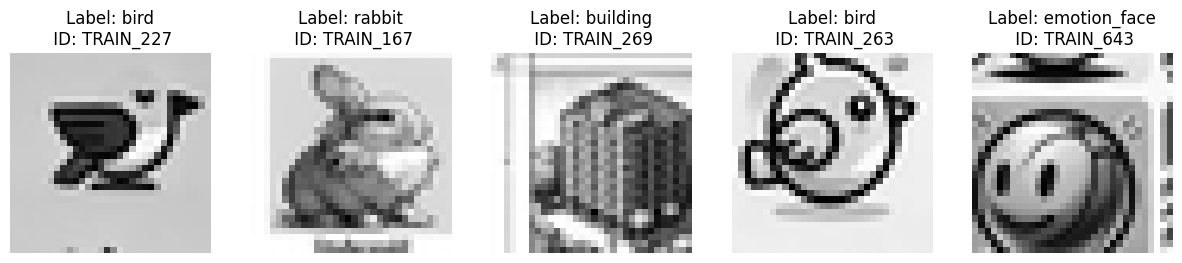

In [77]:
# 이미지 시각화
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i, (idx, sample) in enumerate(samples.iterrows()):
    image_data = sample.iloc[2:].values.astype(np.uint8).reshape(32, 32)  # 32x32 변환 (=1024)
    axes[i].imshow(image_data, cmap='gray')
    axes[i].set_title(f"Label: {sample['label']}\n ID: {sample['ID']}")
    axes[i].axis("off")

# DataSet, DataLoader

In [78]:
# 라벨 인코더 (라벨 -> 숫자)
label_encoder = LabelEncoder()
train['label'] = label_encoder.fit_transform(train["label"])

In [79]:
# 테스트 데이터
test_data = test.iloc[:, 1:].values
test_data

array([[186, 189, 189, ..., 191, 192, 193],
       [209, 219, 227, ..., 219, 219, 214],
       [ 52, 232, 249, ..., 251, 246, 249],
       ...,
       [238, 239, 244, ...,  93,  60, 120],
       [107, 116, 118, ..., 107, 106, 108],
       [168, 169, 171, ..., 164,  93, 100]], shape=(250, 1024))

In [80]:
# 데이터프레임의 인덱스 길이와 20% 샘플링
valid_idx = np.random.choice(len(train), round(len(train) * 0.2), replace=False)
valid_idx = np.sort(valid_idx)  # 정렬

train_idx = np.setdiff1d(train.index, valid_idx)  # valid_idx를 제외한 train 인덱스 계산

print(train_idx, valid_idx)

# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


# for train_idx, valid_idx in skf.split(train.iloc[:, 2:], train['label']):
#     break

# print(train_idx)

[  1   2   3   4   5   6   7   8   9  10  11  12  13  15  17  18  19  20
  21  23  24  25  26  27  28  29  30  31  33  34  35  36  37  38  39  40
  41  42  43  44  45  46  47  48  50  51  52  56  57  58  60  61  62  64
  65  66  67  68  69  70  71  72  73  74  75  76  77  79  80  81  82  83
  84  85  86  87  88  89  90  91  92  93  94  95  96  97  99 100 101 102
 103 104 105 106 107 108 109 110 111 113 114 115 116 117 118 123 124 125
 126 127 128 129 131 132 133 134 135 136 138 139 140 141 142 143 144 145
 147 148 149 151 153 155 156 157 158 160 161 162 163 164 165 167 168 169
 170 171 172 173 174 175 177 178 179 181 182 183 184 185 187 188 192 193
 194 195 196 198 199 201 202 203 205 206 207 208 209 211 212 214 215 216
 217 219 220 221 222 223 224 227 229 232 233 234 235 238 239 240 241 242
 243 244 245 246 247 248 249 252 253 254 255 256 257 258 259 261 262 264
 265 267 268 271 272 273 274 275 276 277 278 280 281 283 284 285 287 288
 289 290 291 293 295 296 297 298 300 301 302 303 30

In [81]:
class CustomDataset():
    def __init__(self,image_df = None, label_df = None, mode = "train", transform = None):
        self.image_df = image_df.reset_index(drop=True)
        # self.label_df = label_df
        self.label_df = label_df.reset_index(drop=True) if label_df is not None else None
        self.transform = transform

    
    def __getitem__(self, idx):
        # Reshape to (32, 32) from flattened data
        image = self.image_df.iloc[idx].values.astype(np.uint8).reshape(32, 32)
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # shape: (1, 32, 32)

        if self.transform:
            image = self.transform(image)

        if self.label_df is not None:
            label = torch.tensor(self.label_df.iloc[idx], dtype=torch.long)
            return image, label
        else:
            return image
        
    def __len__(self):
        return len(self.image_df)

In [82]:
train_transform = Compose([
    ToPILImage(),
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=[0.5], std=[0.5]),
])

In [83]:
train_dataset = CustomDataset(image_df=train.iloc[train_idx, 2:], label_df=train.iloc[train_idx, 1], transform=train_transform)
valid_dataset = CustomDataset(image_df=train.iloc[valid_idx, 2:], label_df=train.iloc[valid_idx, 1], transform=train_transform)
test_dataset = CustomDataset(image_df=test.iloc[:, 1:], transform=train_transform)

In [84]:
loader_params = {
    'batch_size': 5,
    'num_workers': 8,
    'pin_memory': True
}

train_loader = DataLoader(train_dataset, shuffle=True, **loader_params)
valid_loader = DataLoader(valid_dataset, shuffle=False, **loader_params)
test_loader = DataLoader(test_dataset, shuffle=False, **loader_params)

# EarlyStop

In [85]:
class EarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.best_model = None

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.best_model = model.state_dict()  # 모델의 가중치 저장
            self.counter = 0
            if self.verbose:
                print(f"Validation loss decreased. Resetting counter.")
        else:
            self.counter += 1
            if self.verbose:
                print(f"No improvement. Counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True


# Model

In [86]:
# model_id = 'resnet18.tv_in1k'
model_id = 'tf_efficientnet_b0.ns_jft_in1k'
model_name = model_id.split('.')[0]

model = timm.create_model(
        model_id, 
        pretrained=False,
        num_classes=10,
        in_chans=1
    )
model = model.to(device)

In [87]:
EPOCHS = 100

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=5e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

## Training

In [88]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for images, labels in tqdm(loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss

def validate_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct, total = 0, 0
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validation", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(loader.dataset)
    accuracy = correct / total
    return epoch_loss, accuracy

best_loss = float('inf')
best_model = None

# loss, acc 배열
train_losses = []
val_losses = []
val_accuracies = []

# early 정의
early_stopping = EarlyStopping(patience=3, verbose=True)

for epoch in range(EPOCHS):
    print(f"\nEpoch [{epoch+1}/{EPOCHS}]")

    # Train
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)

    # Validate
    val_loss, val_acc = validate_one_epoch(model, valid_loader, criterion, device)

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Accuracy: {val_acc*100:.2f}%")
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Check for best model
    if val_loss < best_loss:
        best_loss = val_loss
        best_model = model
        
        best_acc = val_acc
        
    # Early Stopping 체크
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered.")
        break

    scheduler.step()


Epoch [1/100]


Train Loss: 2.3830 | Val Loss: 4.1170 | Val Accuracy: 21.43%
Validation loss decreased. Resetting counter.

Epoch [2/100]


Train Loss: 1.9990 | Val Loss: 3.1893 | Val Accuracy: 33.77%
Validation loss decreased. Resetting counter.

Epoch [3/100]


Train Loss: 1.8142 | Val Loss: 4.4599 | Val Accuracy: 46.75%
No improvement. Counter: 1/3

Epoch [4/100]


Train Loss: 1.5446 | Val Loss: 3.1747 | Val Accuracy: 43.51%
Validation loss decreased. Resetting counter.

Epoch [5/100]


Train Loss: 1.3124 | Val Loss: 1.9343 | Val Accuracy: 47.40%
Validation loss decreased. Resetting counter.

Epoch [6/100]


Train Loss: 1.1067 | Val Loss: 2.9997 | Val Accuracy: 46.75%
No improvement. Counter: 1/3

Epoch [7/100]


Train Loss: 1.0298 | Val Loss: 2.3385 | Val Accuracy: 53.25%
No improvement. Counter: 2/3

Epoch [8/100]


Train Loss: 0.7998 | Val Loss: 2.1944 | Val Accuracy: 59.09%
No improvement. Counter: 3/3
Early stopping triggered.


In [89]:
# 모델 저장
torch.save(best_model.state_dict(), f'models/{model_name}_best_model.pth')
print(f'Model Save to models/{model_name}_best_model.pth')

Model Save to models/tf_efficientnet_b0_best_model.pth


# acc, loss graph

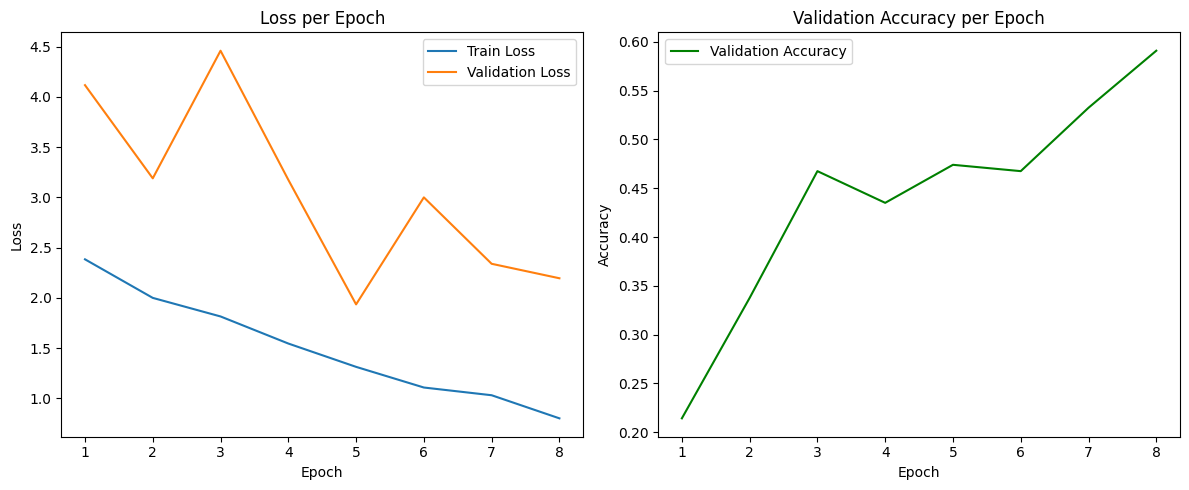

In [90]:
epochs = range(1, len(train_losses)+1)

plt.figure(figsize=(12, 5))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss per Epoch")
plt.legend()

# Accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy per Epoch")
plt.legend()

plt.tight_layout()
plt.show()


# eval

## Print Image

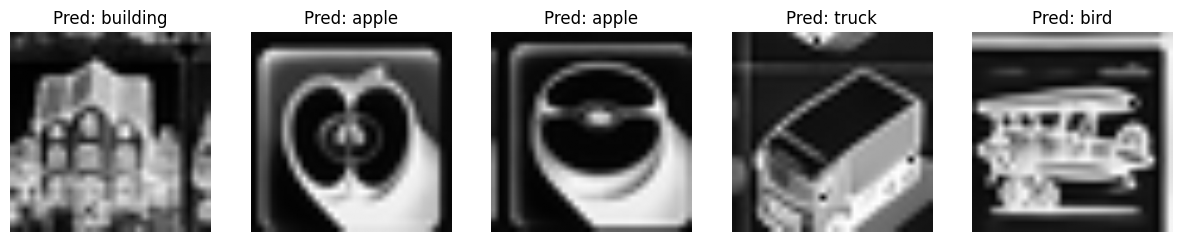

In [91]:
# 테스트 로더에서 랜덤으로 5개 샘플 추출
random_samples = random.sample(range(len(test_loader.dataset)), 5)

# 랜덤으로 추출한 인덱스와 해당 이미지를 추론 및 출력
with torch.no_grad():
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    for idx, sample_idx in enumerate(random_samples):
        # 데이터셋에서 샘플 추출
        sample = test_loader.dataset[sample_idx]  # 단일 샘플 가져오기
        
        # 샘플 형태 확인 및 처리
        if isinstance(sample, tuple) and len(sample) == 2:  # (image, label)
            image, label = sample
        else:  # 레이블 없는 데이터셋일 경우
            image = sample
            label = None
        
        image = image.unsqueeze(0).to(device)  # 배치 차원 추가 및 GPU로 이동
        
        # 모델 추론
        output = best_model(image)
        _, predicted = torch.max(output.data, 1)
        
        # 레이블 디코딩
        pred_label_decoded = label_encoder.inverse_transform([predicted.item()])[0]
        true_label_decoded = label_encoder.inverse_transform([label])[0] if label is not None else None
        
        # 이미지 출력 준비
        image = image.cpu().squeeze()  # GPU → CPU 이동 및 채널 축소
        pred_label = predicted.item()  # 예측된 레이블
        
        # 이미지 시각화
        axes[idx].imshow(image.numpy(), cmap='gray')
        if label is not None:
            axes[idx].set_title(f"True: {true_label_decoded}, Pred: {pred_label_decoded}")
        else:
            axes[idx].set_title(f"Pred: {pred_label_decoded}")
        axes[idx].axis("off")
    
    plt.show()

## Inference & Submission

In [92]:
best_model.eval()
preds = []

with torch.no_grad():
    for images in tqdm(test_loader, desc="Inference", leave=False):
        images = images.to(device)
        outputs = best_model(images)
        _, predicted = torch.max(outputs.data, 1)
        preds.extend(predicted.cpu().numpy())

# Decode predictions
pred_labels = label_encoder.inverse_transform(preds)

submission = pd.read_csv('./data/sample_submission.csv')
submission['label'] = pred_labels
submission.to_csv('baseline_submission.csv', index=False)